## Import libraries and set dataset paths


In [1]:
from pathlib import Path

import datetime
from lib.dataloader import *


# Directory paths for semantic segmentation dataset
root_dir = Path(
    "/home/emilia/msc_ros2/master_ws/src/msc_thesis/offline_utils/train_segmentation/custom_dataset/"
)

dir_test_img = root_dir / "test/images"
dir_test_mask = root_dir / "test/labels"
dir_train_img = root_dir / "train/images"
dir_train_mask = root_dir / "train/labels"
dir_valid_img = root_dir / "valid/images"
dir_valid_mask = root_dir / "valid/labels"

# Directory paths for checkpoints and best models
dir_checkpoint = root_dir / "checkpoints/"
dir_best_model = root_dir / "best_models/"
dir_best_model /= datetime.datetime.now().strftime("%d-%m-%Y-%H-%M")


train_set = SegDataset(dir_train_img, dir_train_mask)
valid_set = SegDataset(dir_valid_img, dir_valid_mask)
test_set = SegDataset(dir_test_img, dir_test_mask)

/home/emilia/.local/lib/python3.10/site-packages/matplotlib/projections/__init__.py:63: UserWarning: Unable to import Axes3D. This may be due to multiple versions of Matplotlib being installed (e.g. as a system package and as a pip package). As a result, the 3D projection is not available.
  warnings.warn("Unable to import Axes3D. This may be due to multiple versions of "


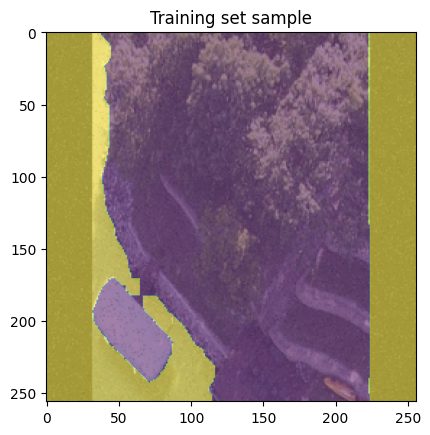

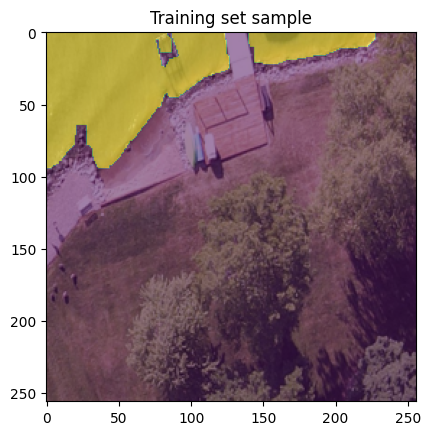

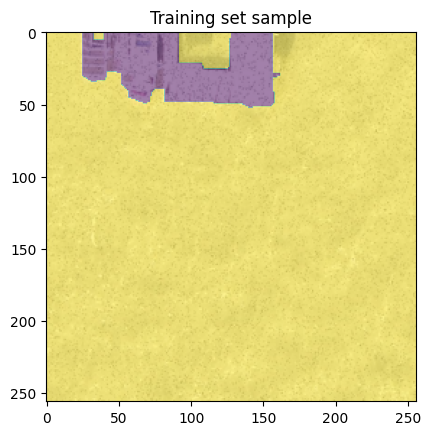

In [2]:
import matplotlib.pyplot as plt

for i in range(6, 15):
    sample = train_set[i]
    img, mask = sample["image"], sample["mask"]
    # for visualization we have to transpose back to HWC
    plt.imshow(np.transpose(img, (1, 2, 0)))
    plt.imshow(mask, alpha=0.5)
    plt.title("Training set sample")
    plt.show()

## Train


In [3]:
from train import *
import segmentation_models_pytorch as smp

model = smp.Unet(
    encoder_name="resnet34",
    encoder_weights="imagenet",
    in_channels=3,
    classes=1,
    activation=None,
)

model = model.to(memory_format=torch.channels_last)

metrics = torchmetrics.MetricCollection(
    torchmetrics.Accuracy(task="binary"),
    torchmetrics.Recall(task="binary"),
    torchmetrics.Precision(task="binary"),
    torchmetrics.JaccardIndex(task="binary", num_classes=2),  # Intersection over Union
    torchmetrics.F1Score(task="binary"),  # Dice Coefficient
)

train_metrics = torchmetrics.MetricTracker(metrics)
val_metrics = torchmetrics.MetricTracker(metrics)


seg_model = SegModel(
    model,
    lr=1e-3,
    optimizer_type="rmsprop",
    train_metrics=train_metrics,
    val_metrics=val_metrics,
    freeze_encoder=False,
)
data_module = SegDataModule(train_set, valid_set, batch_size=4)

timestamp = datetime.datetime.now().strftime("%d-%m-%Y-%H-%M")

# Callbacks
checkpoint_callback = ModelCheckpoint(
    dirpath="checkpoints/",
    save_top_k=1,
    monitor="val_loss",
    mode="min",
    filename="model-{}".format(timestamp),
)
early_stopping = EarlyStopping(
    monitor="val_loss", patience=10, verbose=True, mode="min"
)

trainer = Trainer(
    max_epochs=100,
    gpus=1 if torch.cuda.is_available() else 0,
    callbacks=[checkpoint_callback, early_stopping],
    precision=16,
)

trainer.fit(seg_model, data_module)

/home/emilia/.local/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
INFO:pytorch_lightning.utilities.distributed:Using 16bit native Automatic Mixed Precision (AMP)
INFO:pytorch_lightning.utilities.distributed:GPU available: True, used: True
INFO:pytorch_lightning.utilities.distributed:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.distributed:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.accelerators.gpu:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name                 | Type              | Params
-----------------------------------------------------------
0 | model                | Unet              | 24.4 M
1 | criterion            | BCEWithLogitsLoss | 0     
2 | dice_loss            | DiceLoss          | 0     


Epoch 0: 100%|██████████| 211/211 [00:09<00:00, 21.77it/s, loss=0.567, v_num=2]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved. New best score: 0.428


Epoch 1: 100%|██████████| 211/211 [00:10<00:00, 20.94it/s, loss=0.525, v_num=2]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.027 >= min_delta = 0.0. New best score: 0.401


Epoch 2:   0%|          | 0/211 [00:00<?, ?it/s, loss=0.525, v_num=2]          

/home/emilia/.local/lib/python3.10/site-packages/torchmetrics/utilities/prints.py:36: UserWarning: The ``compute`` method of metric Accuracy was called before the ``update`` method which may lead to errors, as metric states have not yet been updated.
  warnings.warn(*args, **kwargs)
/home/emilia/.local/lib/python3.10/site-packages/torchmetrics/utilities/prints.py:36: UserWarning: The ``compute`` method of metric Recall was called before the ``update`` method which may lead to errors, as metric states have not yet been updated.
  warnings.warn(*args, **kwargs)
/home/emilia/.local/lib/python3.10/site-packages/torchmetrics/utilities/prints.py:36: UserWarning: The ``compute`` method of metric Precision was called before the ``update`` method which may lead to errors, as metric states have not yet been updated.
  warnings.warn(*args, **kwargs)
/home/emilia/.local/lib/python3.10/site-packages/torchmetrics/utilities/prints.py:36: UserWarning: The ``compute`` method of metric JaccardIndex was 

Epoch 3: 100%|██████████| 211/211 [00:12<00:00, 17.29it/s, loss=0.472, v_num=2]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.153 >= min_delta = 0.0. New best score: 0.248


Epoch 8: 100%|██████████| 211/211 [00:12<00:00, 16.51it/s, loss=0.473, v_num=2]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.014 >= min_delta = 0.0. New best score: 0.234


Epoch 10: 100%|██████████| 211/211 [00:12<00:00, 16.47it/s, loss=0.236, v_num=2]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.063 >= min_delta = 0.0. New best score: 0.171


Epoch 11: 100%|██████████| 211/211 [00:12<00:00, 16.36it/s, loss=0.423, v_num=2]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.003 >= min_delta = 0.0. New best score: 0.168


Epoch 12: 100%|██████████| 211/211 [00:12<00:00, 16.49it/s, loss=0.241, v_num=2]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.004 >= min_delta = 0.0. New best score: 0.164


Epoch 19: 100%|██████████| 211/211 [00:12<00:00, 16.69it/s, loss=0.476, v_num=2]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.020 >= min_delta = 0.0. New best score: 0.145


Epoch 20: 100%|██████████| 211/211 [00:13<00:00, 16.09it/s, loss=0.158, v_num=2]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.002 >= min_delta = 0.0. New best score: 0.143


Epoch 29: 100%|██████████| 211/211 [00:12<00:00, 16.43it/s, loss=0.0871, v_num=2]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.007 >= min_delta = 0.0. New best score: 0.135


Epoch 39: 100%|██████████| 211/211 [00:13<00:00, 16.02it/s, loss=0.126, v_num=2] 

INFO:pytorch_lightning.callbacks.early_stopping:Monitored metric val_loss did not improve in the last 10 records. Best score: 0.135. Signaling Trainer to stop.


Epoch 39: 100%|██████████| 211/211 [00:13<00:00, 15.87it/s, loss=0.126, v_num=2]


## Prediction


In [4]:
checkpoint = torch.load(
    "/home/emilia/WaterSegNet/checkpoints/model-14-11-2023-18-58.ckpt"
)
state_dict = checkpoint["state_dict"]

model = smp.Unet(
    encoder_name="resnet34",
    encoder_weights=None,
    in_channels=3,
    classes=1,
    activation=None,
)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
model.load_state_dict(state_dict)

<All keys matched successfully>

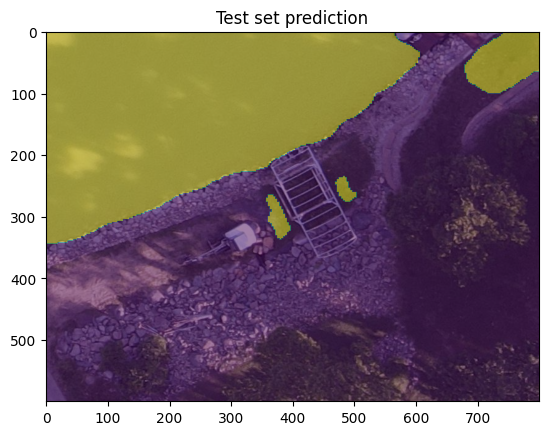

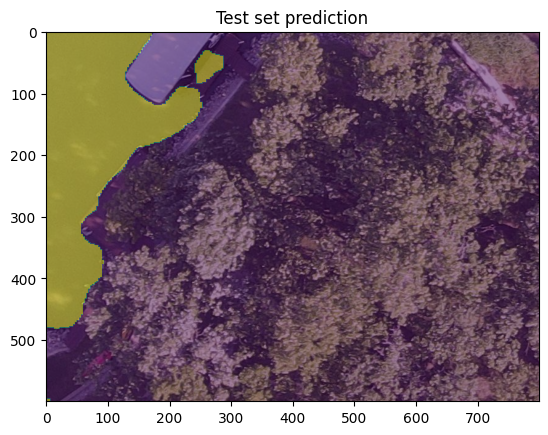

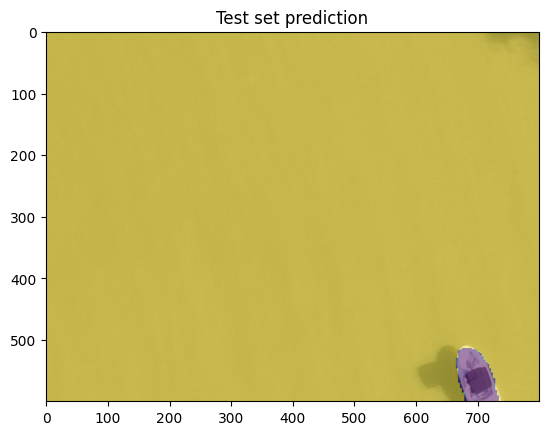

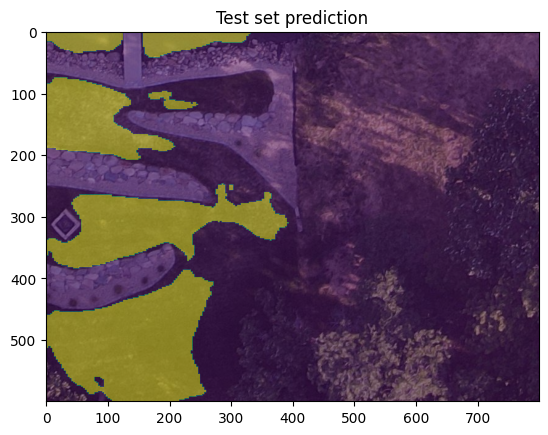

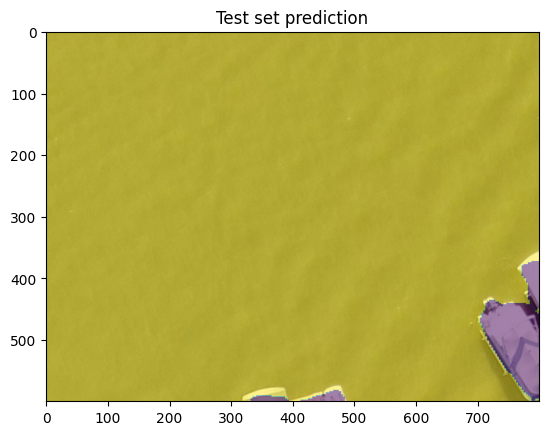

In [5]:
from PIL import Image
import matplotlib.pyplot as plt


def predict_image(model, image, device):
    model.eval()
    img = torch.from_numpy(SegDataset.preprocess(image, is_mask=False))
    img = img.unsqueeze(0).to(device, dtype=torch.float32)
    with torch.no_grad():
        pred = model(img).cpu()
        pred = F.interpolate(pred, size=(image.size[1], image.size[0]))
        mask = torch.sigmoid(pred) > 0.5
        return mask[0].long().squeeze().numpy()


for i in range(1, 10):
    image_raw = Image.open(
        "/home/emilia/WaterSegNet/custom_dataset/test/images/000" + str(i) + ".png"
    )

    plt.imshow(image_raw)
    mask = predict_image(model, image_raw, device)
    plt.imshow(mask, alpha=0.5)
    plt.title("Test set prediction")
    plt.show()

## Evaluate


In [2]:
%load_ext tensorboard
